# 

In [221]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
import seaborn as sns
from joblib import delayed, Parallel
from glob import glob

import sys
sys.path.append("../../")

import tetrahedron
import proj_quality
from metric.metric import Euclid

import pivot_selection
import point_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
files = glob("results/run-2/*.csv")
files += ["results/deduplicated-run-1.csv"]
df = pd.concat((pd.read_csv(f) for f in files))
df = df.drop(columns=["Unnamed: 0"])
df = df.drop_duplicates()
len(set(df.run))

254

In [223]:
failed = df.query("note == 'failed'")
assert set(failed.dim) == {2}
assert set(failed.algorithm) == {"hilbert_optimal"}

# XXX: quick fix: let's exclude dim=2
results = df.query("dim != 2").copy()
assert len(results.query("note == 'failed'")) == 0
assert all(results.hilbert_quality >= 0)
assert all(results.hilbert_quality <= 1)
assert all(results.mean_candidate_set_size > 0)
results = results.drop(columns=["note"])

In [138]:
#u = df.set_index(["dataset","dim","algorithm",])
u = df.copy()
u["dub"] = u.duplicated(["hilbert_quality"], keep=False)
u.groupby("algorithm").dub.sum()
u

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,note,seed,run,dub
0,2,"univariate, idd",random,15.954545,0.818359,NaN,371013602,3710136,True
1,2,"univariate, idd",maximize_dist,15.181818,0.822266,NaN,371013602,3710136,True
2,2,"univariate, idd",non_central_points,8.909091,0.855469,NaN,371013602,3710136,True
3,2,"univariate, idd",non_central_points_approx,15.318182,0.839844,NaN,371013602,3710136,True
4,2,"univariate, idd",remoteness,9.000000,0.855469,NaN,371013602,3710136,True
...,...,...,...,...,...,...,...,...,...
67387,17,"clusters, sparse",remoteness,126.045455,0.916016,NaN,6417,64,True
67388,17,"clusters, sparse",central_and_distant,125.818182,0.500000,NaN,6417,64,True
67389,17,"clusters, sparse",different_cluster_centers,171.000000,1.000000,NaN,6417,64,True
67390,17,"clusters, sparse",hilbert_optimal,195.090909,1.000000,NaN,6417,64,True


In [156]:
len(results)

205740

In [158]:
results.query("hilbert_quality == 0")

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,seed,run
615,13,"gaussian, circular",non_central_points_approx,491.636364,0.0,371013613,3710136
674,14,"gaussian, circular",ccs_optimal,420.909091,0.0,371013614,3710136
704,15,"univariate, idd",non_central_points,435.772727,0.0,371013615,3710136
720,15,"gaussian, circular",random,505.045455,0.0,371013615,3710136
771,16,"univariate, stretched",different_cluster_centers,499.863636,0.0,371013616,3710136
...,...,...,...,...,...,...,...
67310,16,"gaussian, circular",ccs_optimal,448.772727,0.0,6416,64
67353,17,"univariate, stretched",different_cluster_centers,495.727273,0.0,6417,64
67355,17,"univariate, stretched",ccs_optimal,408.136364,0.0,6417,64
67356,17,"gaussian, circular",random,500.818182,0.0,6417,64


In [166]:
u = results.groupby(["dataset","dim","algorithm",]).apply(len, include_groups=False)
assert len(set(u)) == 1
print(f"samples per (`dataset` x `dim` x `algorithm`) combination: {set(u)}")

samples per (`dataset` x `dim` x `algorithm`) combination: {254}


In [96]:

# drop_ratio = 0.25
# measure = "hilbert_quality"
# def _drop_worst(group:pd.DataFrame):
    # thresh = group[measure].quantile(drop_ratio)
    # return group[group[measure] > thresh]
    
# normalized_res = results.groupby(["dim","dataset", "algorithm"]).apply(_drop_worst, include_groups=False)
# normalized_res = normalized_res.reset_index()#.drop(columns="level_2")
# assert np.allclose(1-len(normalized_res)/len(results), drop_ratio,atol=0.05)


In [97]:
# measure = "hilbert_quality"
# def _discard_if_worse_than_random(group):
    # group = group.reset_index(drop=True)
    # mean = group.groupby("algorithm")[measure].mean()
    # std =  group.groupby("algorithm")[measure].std()
    # thresh = mean["random"] - std["random"]
    # discard = mean.index[mean < thresh]
    # return group[~group.algorithm.isin(discard)]
# 
# # drop stuff worse than random
# normalized_res = normalized_res.groupby(["dim","dataset"]).apply(_discard_if_worse_than_random, include_groups=False)#.reset_index(drop=False)
# normalized_res = normalized_res.reset_index().drop(columns="level_2")

In [ ]:
def _normalize_difficulty(df, points_column, optimal_algorithm, higher_is_better=True):
    df = df.copy()
    if not higher_is_better:
        df[points_column] = -df[points_column]

    # set highest score to 1
    only_optimal = df.query("algorithm == @optimal_algorithm")
    df[points_column] /= only_optimal[points_column].mean()

    # set lowest score to 0
    
    # higher is better
    lower_bound = df.query("algorithm == 'random'").hilbert_quality.mean()
    df.hilbert_quality -= lower_bound
    upper_bound = df.query("algorithm == 'hilbert_optimal'").hilbert_quality.mean()
    df.hilbert_quality /= upper_bound

    # add candidate set quality
    # best_result = df.query("algorithm == 'ccs_optimal'").mean_candidate_set_size.mean()
    # # 0 is optimal
    # df["csq"] = best_result - df.mean_candidate_set_size
    # # # 0 is random
    # df["csq"] -= df.query("algorithm == 'random'").csq.mean()
    # # 1 is optimal
    # df["csq"] /= df.query("algorithm == 'ccs_optimal'").csq.mean()
    # df = df.rename(columns=dict(csq="mean_candidate_set_quality"))
    
    # lower is better
    lower_bound = df.query("algorithm == 'ccs_optimal'").mean_candidate_set_size.mean()
    df.mean_candidate_set_size -= lower_bound
    upper_bound = df.query("algorithm == 'random'").mean_candidate_set_size.mean()
    df.mean_candidate_set_size /= upper_bound

    return df

# TODO: Decide on whether to normalize per run (grp + ["run"])
# TODO: Choose whether to do candidate set size or quality (maybe just invert the y-axis visially only?)
# TODO: Choose color scheme for beyond 1 and 0 filly

grp = ["dataset", "dim"]  #"run"]
normalized_res = results.groupby(grp).apply(
    _normalize, include_groups=False
)
normalized_res = normalized_res.reset_index(level=grp)
normalized_res

#assert all(normalized_res.query("algorithm != 'hilbert_optimal'").hilbert_quality <= 2)
ex = normalized_res.query("dataset == 'univariate, stretched'")
sns.lineplot(ex, x="dim", y="hilbert_quality", hue="algorithm")

<Axes: xlabel='dim', ylabel='hilbert_quality'>

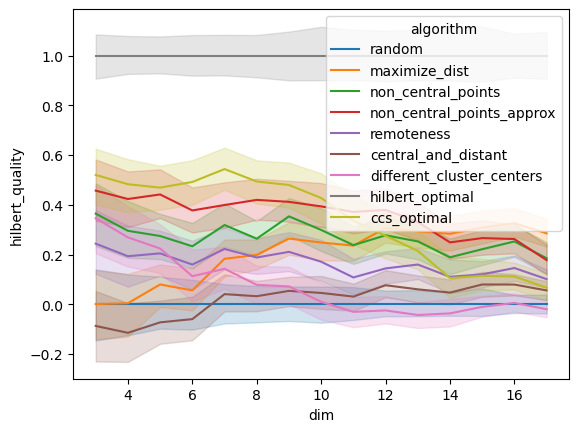

In [167]:
def _normalize(df):
    # higher is better
    lower_bound = df.query("algorithm == 'random'").hilbert_quality.mean()
    df.hilbert_quality -= lower_bound
    upper_bound = df.query("algorithm == 'hilbert_optimal'").hilbert_quality.mean()
    df.hilbert_quality /= upper_bound

    # add candidate set quality
    # best_result = df.query("algorithm == 'ccs_optimal'").mean_candidate_set_size.mean()
    # # 0 is optimal
    # df["csq"] = best_result - df.mean_candidate_set_size
    # # # 0 is random
    # df["csq"] -= df.query("algorithm == 'random'").csq.mean()
    # # 1 is optimal
    # df["csq"] /= df.query("algorithm == 'ccs_optimal'").csq.mean()
    # df = df.rename(columns=dict(csq="mean_candidate_set_quality"))
    
    # lower is better
    lower_bound = df.query("algorithm == 'ccs_optimal'").mean_candidate_set_size.mean()
    df.mean_candidate_set_size -= lower_bound
    upper_bound = df.query("algorithm == 'random'").mean_candidate_set_size.mean()
    df.mean_candidate_set_size /= upper_bound

    return df

# TODO: Decide on whether to normalize per run (grp + ["run"])
# TODO: Choose whether to do candidate set size or quality (maybe just invert the y-axis visially only?)
# TODO: Choose color scheme for beyond 1 and 0 filly

grp = ["dataset", "dim"]  #"run"]
normalized_res = results.groupby(grp).apply(
    _normalize, include_groups=False
)
normalized_res = normalized_res.reset_index(level=grp)
normalized_res

#assert all(normalized_res.query("algorithm != 'hilbert_optimal'").hilbert_quality <= 2)
ex = normalized_res.query("dataset == 'univariate, stretched'")
sns.lineplot(ex, x="dim", y="hilbert_quality", hue="algorithm")

<Axes: xlabel='dim', ylabel='hilbert_quality'>

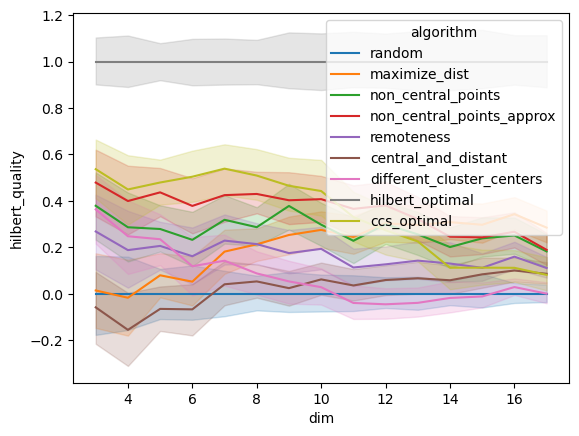

In [93]:
def _normalize(df):
    # higher is better
    lower_bound = df.query("algorithm == 'random'").hilbert_quality.mean()
    df.hilbert_quality -= lower_bound
    upper_bound = df.query("algorithm == 'hilbert_optimal'").hilbert_quality.mean()
    df.hilbert_quality /= upper_bound

    # add candidate set quality
    # best_result = df.query("algorithm == 'ccs_optimal'").mean_candidate_set_size.mean()
    # # 0 is optimal
    # df["csq"] = best_result - df.mean_candidate_set_size
    # # # 0 is random
    # df["csq"] -= df.query("algorithm == 'random'").csq.mean()
    # # 1 is optimal
    # df["csq"] /= df.query("algorithm == 'ccs_optimal'").csq.mean()
    # df = df.rename(columns=dict(csq="mean_candidate_set_quality"))
    
    # lower is better
    lower_bound = df.query("algorithm == 'ccs_optimal'").mean_candidate_set_size.mean()
    df.mean_candidate_set_size -= lower_bound
    upper_bound = df.query("algorithm == 'random'").mean_candidate_set_size.mean()
    df.mean_candidate_set_size /= upper_bound

    return df

# TODO: Decide on whether to normalize per run (grp + ["run"])
# TODO: Choose whether to do candidate set size or quality (maybe just invert the y-axis visially only?)
# TODO: Choose color scheme for beyond 1 and 0 filly

grp = ["dataset", "dim"]  #"run"]
normalized_res = results.groupby(grp).apply(
    _normalize, include_groups=False
)
normalized_res = normalized_res.reset_index(level=grp)
normalized_res

#assert all(normalized_res.query("algorithm != 'hilbert_optimal'").hilbert_quality <= 2)
ex = normalized_res.query("dataset == 'univariate, stretched'")
sns.lineplot(ex, x="dim", y="hilbert_quality", hue="algorithm")

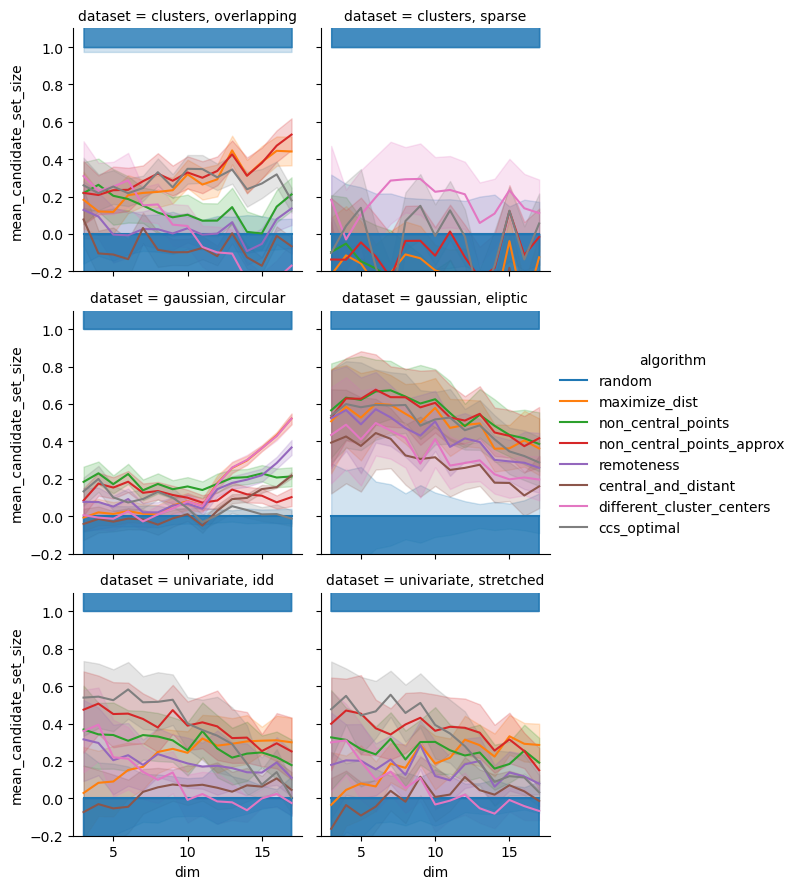

In [78]:
g = sns.FacetGrid(
    data=normalized_res.query("algorithm != 'hilbert_optimal'"),
    col="dataset",
    hue="algorithm",
    col_wrap=2,
)

def plot_single(x,y, **kwargs):
    data = kwargs.pop('data')
    #sns.lineplot(data=data,x=x,y=y, **kwargs)
    ax = plt.gca()
    ax.fill_between(data[x], 1, ax.get_ylim()[1], alpha=0.2, color="C0")
    ax.fill_between(data[x], 0, ax.get_ylim()[0], alpha=0.2, color="C0")
    
g.map(sns.lineplot, "dim", "hilbert_quality")
g.map_dataframe(plot_single, "dim", "mean_candidate_set_size")

g.set(ylim=(-0.2, 1.1))
g.add_legend()
g.savefig("fig/css.svg")

In [172]:
results

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,seed,run
54,3,"univariate, idd",random,36.863636,0.580078,371013603,3710136
55,3,"univariate, idd",maximize_dist,68.545455,0.607422,371013603,3710136
56,3,"univariate, idd",non_central_points,42.409091,0.603516,371013603,3710136
57,3,"univariate, idd",non_central_points_approx,42.318182,0.687500,371013603,3710136
58,3,"univariate, idd",remoteness,68.545455,0.607422,371013603,3710136
...,...,...,...,...,...,...,...
67387,17,"clusters, sparse",remoteness,126.045455,0.916016,6417,64
67388,17,"clusters, sparse",central_and_distant,125.818182,0.500000,6417,64
67389,17,"clusters, sparse",different_cluster_centers,171.000000,1.000000,6417,64
67390,17,"clusters, sparse",hilbert_optimal,195.090909,1.000000,6417,64


In [189]:
def _better_than_random(df, score):
    rv = pd.DataFrame(index=df.algorithm.unique())
    rv.index.name = "algorithm"
    df = df.sort_values(["dataset", "dim", "run", "seed"])
    random = df.query("algorithm == 'random'")[score]
    
    for alg in rv.index:
        this_alg = df.query("algorithm == @alg")[score]
        better = (this_alg.to_numpy() > random.to_numpy()).sum()
        total = len(this_alg)
        rv.loc[alg, "chance_better_than_random"] = better / total

    return rv

better = results.groupby(["dim", "dataset"]).apply(lambda x:_better_than_random(x, "hilbert_quality")) 

better

/tmp/ipykernel_297930/2642168507.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  better = results.groupby(["dim", "dataset"]).apply(lambda x:_better_than_random(x, "hilbert_quality"))


chance_better_than_random
dim dataset               algorithm                                           
3   clusters, overlapping random                                      0.000000
                          maximize_dist                               0.614173
                          non_central_points                          0.665354
                          non_central_points_approx                   0.645669
                          remoteness                                  0.602362
...                                                                        ...
17  univariate, stretched remoteness                                  0.602362
                          central_and_distant                         0.503937
                          different_cluster_centers                   0.425197
                          hilbert_optimal                             1.000000
                          ccs_optimal                                 0.440945

[810 rows x 1 columns]

In [247]:
samples

dim  dataset              
3    clusters, overlapping    2286
     clusters, sparse         2286
     gaussian, circular       2286
     gaussian, eliptic        2286
     univariate, idd          2286
                              ... 
17   clusters, sparse         2286
     gaussian, circular       2286
     gaussian, eliptic        2286
     univariate, idd          2286
     univariate, stretched    2286
Name: algorithm, Length: 90, dtype: int64

In [254]:
results.query("algorithm != 'hilbert_optimal'")

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,seed,run
54,3,"univariate, idd",random,36.863636,0.580078,371013603,3710136
55,3,"univariate, idd",maximize_dist,68.545455,0.607422,371013603,3710136
56,3,"univariate, idd",non_central_points,42.409091,0.603516,371013603,3710136
57,3,"univariate, idd",non_central_points_approx,42.318182,0.687500,371013603,3710136
58,3,"univariate, idd",remoteness,68.545455,0.607422,371013603,3710136
...,...,...,...,...,...,...,...
67386,17,"clusters, sparse",non_central_points_approx,126.090909,0.988281,6417,64
67387,17,"clusters, sparse",remoteness,126.045455,0.916016,6417,64
67388,17,"clusters, sparse",central_and_distant,125.818182,0.500000,6417,64
67389,17,"clusters, sparse",different_cluster_centers,171.000000,1.000000,6417,64


In [258]:
df

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,seed,run
54,3,"univariate, idd",random,36.863636,0.580078,371013603,3710136
55,3,"univariate, idd",maximize_dist,68.545455,0.607422,371013603,3710136
56,3,"univariate, idd",non_central_points,42.409091,0.603516,371013603,3710136
57,3,"univariate, idd",non_central_points_approx,42.318182,0.687500,371013603,3710136
58,3,"univariate, idd",remoteness,68.545455,0.607422,371013603,3710136
...,...,...,...,...,...,...,...
67386,17,"clusters, sparse",non_central_points_approx,126.090909,0.988281,6417,64
67387,17,"clusters, sparse",remoteness,126.045455,0.916016,6417,64
67388,17,"clusters, sparse",central_and_distant,125.818182,0.500000,6417,64
67389,17,"clusters, sparse",different_cluster_centers,171.000000,1.000000,6417,64


In [266]:
win_percent

dim  dataset                algorithm                
3    clusters, overlapping  ccs_optimal                  0.023622
                            central_and_distant          0.015748
                            different_cluster_centers    0.029528
                            maximize_dist                0.008366
                            non_central_points           0.023130
                                                           ...   
17   univariate, stretched  maximize_dist                0.058071
                            non_central_points           0.035433
                            non_central_points_approx    0.030512
                            random                       0.003445
                            remoteness                   0.024606
Length: 720, dtype: float64

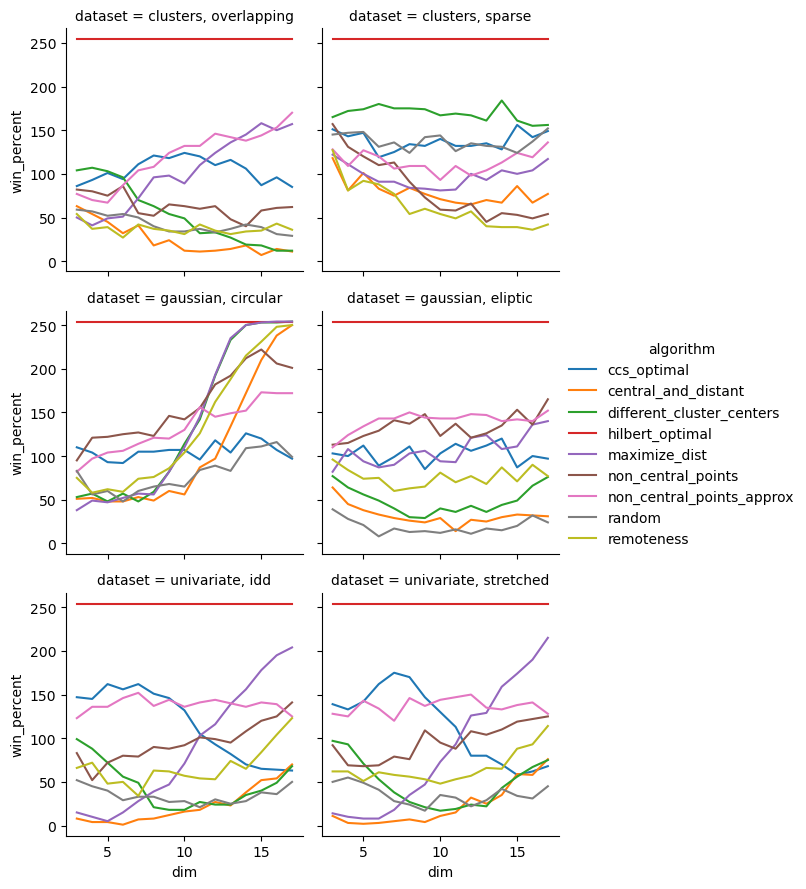

In [271]:
def _is_in_top_k(df, score, k=3):
    df = df.copy()
    grp = df.groupby(["dataset", "dim", "run", "seed"])
    is_winner = grp.hilbert_quality.rank("dense", ascending=False) <= k
    df["winner"] = False
    df.loc[is_winner, "winner"] = True
    return df

df = results.copy() #results.query("algorithm != 'hilbert_optimal'").copy()
is_winner = _is_in_top_k(df, "hilbert_quality", k=3)
wins = is_winner.groupby(["dim", "dataset", "algorithm"]).winner.sum()
samples = df.reset_index().groupby(["dim", "dataset"]).algorithm.count()
win_percent = wins #/ samples
win_percent.name = "win_percent"

g = sns.FacetGrid(
    data=win_percent.reset_index(),
    col="dataset",
    hue="algorithm",
    col_wrap=2,
)
g.map(sns.lineplot, "dim", "win_percent")
g.add_legend()


In [248]:
winner_percent.reset_index().query("dim == 3 and dataset == 'clusters, sparse'")

,dim,dataset,algorithm,winner
9,3,"clusters, sparse",ccs_optimal,0.291339
10,3,"clusters, sparse",central_and_distant,0.259843
11,3,"clusters, sparse",different_cluster_centers,0.397638
12,3,"clusters, sparse",hilbert_optimal,1.000000
13,3,"clusters, sparse",maximize_dist,0.244094
14,3,"clusters, sparse",non_central_points,0.342520
15,3,"clusters, sparse",non_central_points_approx,0.307087
16,3,"clusters, sparse",random,0.342520
17,3,"clusters, sparse",remoteness,0.279528


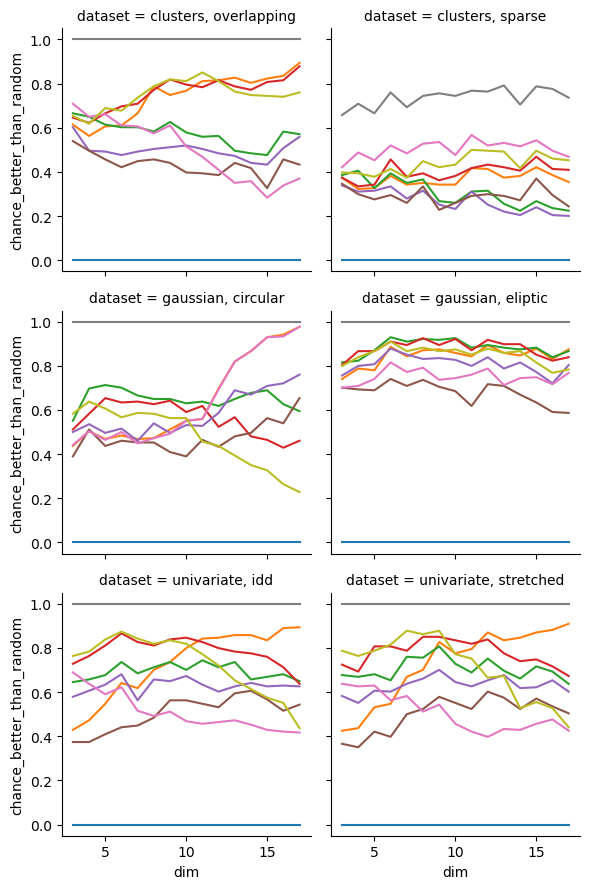

In [188]:
g = sns.FacetGrid(
    data=better.reset_index(),
    col="dataset",
    hue="algorithm",
    col_wrap=2,
)
g.map(sns.lineplot, "dim", "chance_better_than_random")